In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from functools import lru_cache
import os
from scipy.spatial.distance import pdist, squareform

In [28]:
input_dim = 400
num_points = 50
hidden_dim = 128
batch_size = 32
epochs = 100
lr = 0.001

In [13]:
size = 10
@lru_cache(maxsize=1024)
def configs(conc):
    df = {}
    for x in range(5000):
        path = os.path.expanduser(f'~/Downloads/transmissions/size_10/lead_size_10_conc_{conc}_config_{x}.csv')
        new_data = np.loadtxt(path, delimiter=',',skiprows=1)[:,1]
        df[x] = new_data
    df = pd.DataFrame(df)
#    df.index = np.arange(0, 4, 0.01)
    return df.clip(upper=size)


DEVICE_COMBS = {}

@lru_cache(maxsize=1024)
def chosen_for_config(n, size, config):
    width = int(size); n = int(n); cfg = int(config)
    if width not in DEVICE_COMBS:
        DEVICE_COMBS[width] = np.array([(i, j) for i in range(100) for j in range(width)], dtype=int)
    device_combs = DEVICE_COMBS[width]
    rng = np.random.RandomState(cfg)
    chosen_indices = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[chosen_indices]


def possible_combs(n, width):
    def combs_for_seed(x):
        return chosen_for_config(n, width, x)
    return combs_for_seed

@lru_cache(maxsize=1024)
def distance_matrix(conc,config):
    imps  = possible_combs(conc, size)
    item = imps(config)
    #print(np.diag(item[:,1]))
    x = np.stack((size - item[:,1],item[:,1]), axis=1)
    return squareform(pdist(item, metric='euclidean')) + np.diag(x.min(axis=1))

In [15]:
configs_7 = configs(7)
configs_7

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,10.000000,1.000000e+01,10.000000,6.488021e+00,1.000000e+01,3.940534,10.000000,7.574875e+00,1.000000e+01,10.000000,...,10.000000,1.000000e+01,10.000000,8.305396e+00,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000
1,7.006579,7.645835e+00,7.192661,7.585422e+00,7.393768e+00,7.847306,7.433356,6.993722e+00,7.934264e+00,6.918293,...,6.693646,8.123208e+00,7.180098,8.174807e+00,7.667001e+00,7.282865,7.626368,7.660367,7.529262,7.855872
2,7.109862,7.721084e+00,6.968077,7.627945e+00,7.595367e+00,7.997086,7.252777,7.532265e+00,8.027496e+00,6.755123,...,7.083734,7.976898e+00,7.019901,7.898473e+00,7.112251e+00,7.035960,7.786541,7.219781,7.820761,7.771694
3,7.134828,7.777070e+00,6.904487,7.900505e+00,7.721516e+00,7.697289,7.330754,7.210707e+00,7.944317e+00,6.855284,...,7.048564,7.876257e+00,7.048302,7.672065e+00,7.476574e+00,7.420236,7.580862,7.006135,7.736227,7.759808
4,7.055721,7.854801e+00,7.069879,7.780227e+00,7.624889e+00,7.762750,7.223874,7.057276e+00,8.048848e+00,6.839404,...,7.089951,7.867549e+00,6.255548,7.916745e+00,7.639982e+00,7.544340,7.641974,7.547264,7.786825,7.623887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,10.000000,2.593482e-06,0.573249,2.593482e-06,2.593482e-06,1.712943,10.000000,2.593482e-06,2.593482e-06,0.018009,...,1.542146,2.593482e-06,1.346781,7.370393e-02,2.593482e-06,0.255871,1.787961,0.053220,10.000000,2.736218
396,0.310267,1.489599e-06,2.764312,1.489599e-06,1.489599e-06,2.638750,0.448296,1.489599e-06,1.489599e-06,10.000000,...,1.121634,1.489599e-06,10.000000,1.000000e+01,1.489599e-06,1.742261,10.000000,0.009066,0.064087,0.029242
397,0.619827,9.684680e-07,1.626069,9.684680e-07,9.684680e-07,0.253304,0.508884,9.684680e-07,9.684680e-07,0.199489,...,0.493740,9.684680e-07,0.036108,3.576915e-02,9.684680e-07,0.041831,0.209843,0.754811,4.121519,0.807666
398,10.000000,6.817701e-07,3.457110,6.817701e-07,6.817701e-07,0.027617,2.483520,6.817701e-07,6.817701e-07,0.089678,...,0.033469,6.817701e-07,0.607491,6.817701e-07,6.817701e-07,0.053473,6.784274,0.007624,0.129204,0.908893


In [16]:
def create_dataset():
    x = []
    y = []
    for conc in np.arange(7,50,2):
        print(f"Processing concentration: {conc}")
        for config in range(5000):
            dist_mat = 0 *np.eye(50)
            dist_mat[:conc,:conc] +=  distance_matrix(conc, config)
            path = os.path.expanduser(f'~/Downloads/transmissions/size_10/lead_size_10_conc_{conc}_config_{config}.csv')
            new_data = np.loadtxt(path, delimiter=',',skiprows=1)[:,1]
            #arr = configs(conc).index,configs(conc)[config]
            #arr = np.array(arr).T
            y.append(dist_mat)
            x.append(new_data)


    x = np.array(x)
    y = np.array(y)
    print(f"Shape of x: {x.shape}")
    print(f"Shape of y: {y.shape}")

    return x,y

x,y = create_dataset()

Processing concentration: 7
Processing concentration: 9
Processing concentration: 11
Processing concentration: 13
Processing concentration: 15
Processing concentration: 17
Processing concentration: 19
Processing concentration: 21
Processing concentration: 23
Processing concentration: 25
Processing concentration: 27
Processing concentration: 29
Processing concentration: 31
Processing concentration: 33
Processing concentration: 35
Processing concentration: 37
Processing concentration: 39
Processing concentration: 41
Processing concentration: 43
Processing concentration: 45
Processing concentration: 47
Processing concentration: 49
Shape of x: (110000, 400)
Shape of y: (110000, 50, 50)


In [17]:
n_train = int(0.8 * x.shape[0])
n_val = x.shape[0] - n_train

In [34]:
train_ds, val_ds = torch.utils.data.random_split(x, [n_train, n_val], generator=torch.Generator().manual_seed(42))

In [35]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

(110000, 400)

In [43]:

class SensorDistanceDataset(Dataset):
    def __init__(self, x, y, dtype=torch.float32):
        """
        x: numpy array or tensor of shape (N, 400, 2)
        y: numpy array or tensor of shape (N, 50, 50)
        """
        
        self.x = torch.as_tensor(x, dtype=dtype)
        self.y = torch.as_tensor(y, dtype=dtype)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [47]:
dataset = SensorDistanceDataset(x, y)
val_loader = DataLoader(dataset, batch_size=32, shuffle=False)


In [ ]:
class distance_matrix_nn(nn.Module):
    def __init__(self, input_dim = 400, num_points = 50, hidden_dim = 256):
        super(distance_matrix_nn, self).__init__()
        self.input_dim = input_dim
        self.output_dim = num_points * num_points

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.output_dim)
        )

        self.softplus = nn.Softplus()

    def forward(self, x):
        out = self.net(x)
        out = self.softplus(out)
        D = out.view(-1,50,50)
        return D        
        self.x = torch.as_tensor(x, dtype=dtype)
        self.y = torch.as_tensor(y, dtype=dtype)
    


In [62]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Create dataset + dataloader
dataset = SensorDistanceDataset(x, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model + optimizer
model = distance_matrix_nn(input_dim, num_points=50, hidden_dim=256)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(1000):  # increase epochs later
    total_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        preds = model(xb)           # (B, 50, 50)
        loss = F.mse_loss(preds, yb.view(-1, 50, 50))  # compare with true (50,50)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()        
        self.x = torch.as_tensor(x, dtype=dtype)
        self.y = torch.as_tensor(y, dtype=dtype)
    

    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.6f}")


NameError: name 'dtype' is not defined

In [63]:
def offdiag_mse(pred, target):
    # pred, target: (B, N, N)
    N = pred.size(-1)
    eye = torch.eye(N, device=pred.device).bool()
    mask = ~eye  # off-diagonal True
    diff = pred - target
    diff = diff[:, mask]
    return (diff ** 2).mean()

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        D = model(x)
        loss = offdiag_mse(D, y)
        losses.append(loss.item())
    return sum(losses) / len(losses)

In [65]:
model = distance_matrix_nn(input_dim=input_dim, num_points=num_points, hidden_dim=hidden_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)

best_val = float("inf")
for epoch in range(1, epochs + 1):
    model.train()
    running = 0.0
    for a, b in train_loader:
        a, b = a.to(device), b.to(device)
        
        D = model(a)
        loss = offdiag_mse(D, b)
        
        opt.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # safe training
        opt.step()

        running += loss.item() * a.size(0)

    train_loss = running / len(train_loader.dataset)
    val_loss   = evaluate(model, val_loader, device)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_distance_model.pt")
    print(f"Epoch {epoch:02d} | train {train_loss:.4f} | val {val_loss:.4f}")


ValueError: too many values to unpack (expected 2)

In [ ]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    losses = []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        D = model(x)
        loss = offdiag_mse(D, y)
        losses.append(loss.item())
    return sum(losses) / len(losses)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [48]:
# Load best weights (optional)
#model.load_state_dict(torch.load("best_distance_model.pt", map_location="cpu"))
model.eval()

x_sample, y_true = next(iter(val_loader))
x_sample = x_sample.to("cpu")
with torch.no_grad():
    y_pred = model(x_sample)  # (B, N, N)

print("Pred shape:", y_pred.shape)
print("Example pred D[0]:\n", y_pred[0].cpu())
print("Example true D[0]:\n", y_true[0])


Pred shape: torch.Size([32, 50, 50])
Example pred D[0]:
 tensor([[2.9372e+00, 3.6222e+01, 3.0929e+01,  ..., 3.5101e-19, 1.1753e-19,
         0.0000e+00],
        [3.6269e+01, 2.2418e+00, 3.0293e+01,  ..., 5.9539e-18, 8.1839e-19,
         0.0000e+00],
        [3.0907e+01, 3.0337e+01, 2.6812e+00,  ..., 1.1924e-15, 2.3310e-19,
         9.9772e-43],
        ...,
        [2.8353e-19, 7.4006e-18, 1.1427e-15,  ..., 0.0000e+00, 1.2639e-14,
         0.0000e+00],
        [1.4359e-19, 6.6676e-19, 1.9159e-19,  ..., 1.3147e-14, 4.4281e-43,
         2.1439e-40],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 5.3698e-42,
         0.0000e+00]])
Example true D[0]:
 tensor([[ 3.0000, 15.2315, 70.1783,  ...,  0.0000,  0.0000,  0.0000],
        [15.2315,  1.0000, 56.0089,  ...,  0.0000,  0.0000,  0.0000],
        [70.1783, 56.0089,  2.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000

In [51]:
y_pred[0].shape

torch.Size([50, 50])

In [52]:
y_true[0].shape

torch.Size([50, 50])

In [53]:
diff = y_pred[0] - y_true[0]

In [60]:
diff.mean()

0.10295077

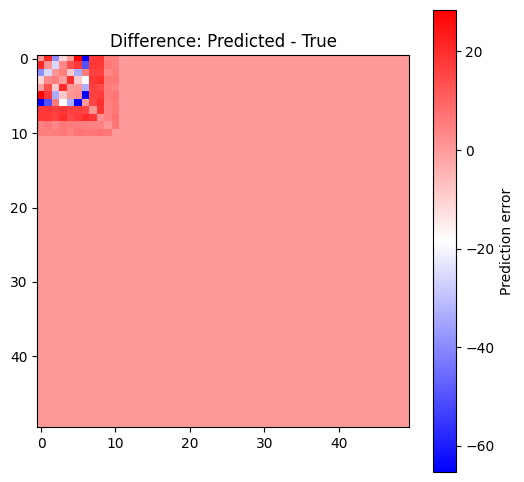

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose y_pred, y_true are tensors of shape (B, 50, 50)
diff = y_pred[0] - y_true[0]    # first sample
diff = diff.detach().cpu().numpy()  # convert to NumPy if on GPU

plt.figure(figsize=(6,6))
plt.imshow(diff, cmap='bwr', interpolation='nearest')
plt.colorbar(label='Prediction error')
plt.title("Difference: Predicted - True")
plt.show()


In [61]:
print("Max error:", np.max(diff))
print("Min error:", np.min(diff))
print("Mean absolute error:", np.mean(np.abs(diff)))


Max error: 28.393648
Min error: -65.274704
Mean absolute error: 0.6783266
